<a href="https://colab.research.google.com/github/lmkwytnicholas/nic.github.io/blob/master/amazonSentimentAnalysisBowTfidf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Access & EDA

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='white',color_codes=True)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# SQLite Table to read data
con = sqlite3.connect('/content/drive/MyDrive/Tech I.S./00 Datasets/nlp/database.sqlite')

In [ ]:
con_rev = pd.read_sql_query(""" SELECT * FROM Reviews """, con)
print(con_rev.shape)
print(con_rev.head())

(568454, 10)
   Id  ...                                               Text
0   1  ...  I have bought several of the Vitality canned d...
1   2  ...  Product arrived labeled as Jumbo Salted Peanut...
2   3  ...  This is a confection that has been around a fe...
3   4  ...  If you are looking for the secret ingredient i...
4   5  ...  Great taffy at a great price.  There was a wid...

[5 rows x 10 columns]


In [ ]:
# Filter only positive and negative reviews i.e. reviews without a rating of 3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con)
print(filtered_data.shape)
filtered_data.head(10)

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [ ]:
# Define function to further group 
# score>3 as Positive (1)
# score>3 as Negative (0)
def partition(x):
  if x<3:
    return 0
  return 1

In [ ]:
# Apply function to dataset
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative
print('Number of Observations:',filtered_data.shape)
filtered_data.head(5)

Number of Observations: (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
# Data cleaning - dedup
subset = {'UserId', 'ProfileName', 'Time', 'Text'}
data = filtered_data.drop_duplicates(subset=subset,keep='first')
print(data.shape)
data.head(3)

(364173, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [ ]:
# Check % of data that remains
(data['Id'].size)/(filtered_data['Id'].size)*100

69.25890143662969

In [ ]:
# HelpfulnessNumerator - number of users who found the review helpful
# HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not

# Check whether 'HelpfulnessNumerator' is always less than or equal to 'HelpfulnessDenominator'
data[data['HelpfulnessNumerator']>data['HelpfulnessDenominator']]

# HelpfullnessNumerator cannot be greater than HelpfulnessDenominator
# Updating dataframe where 'HelpfulnessNumerator' is less than or equal to 'HeplfulnessDenominator'

data = data[data['HelpfulnessNumerator'] <= data['HelpfulnessDenominator']]
data.reset_index(drop=True,inplace=True)
print(data.shape)
data.head(3)

(364171, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [ ]:
# Identify missing values
miss_val = data.isna().sum()
miss_val

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

1    307061
0     57110
Name: Score, dtype: int64
**************************************************


Text(0.5, 1.0, 'Score Distribution')

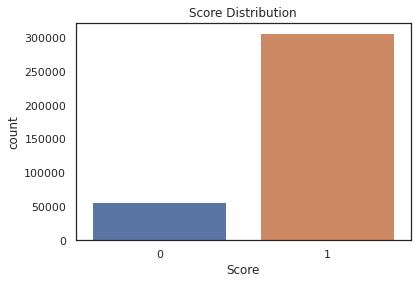

In [ ]:
# Count of each class
print(data['Score'].value_counts())
print('*'*50)
# Countplot for 'Score'
sns.countplot('Score',data=data)
plt.title('Score Distribution')

#Text Preprocessing
* Stemming
* Stopword Removal
* Lemmatization

In [ ]:
# Stopwords
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

# Initialize snowball stemmer
sno = nltk.stem.SnowballStemmer('english')

# Function to clean the word of any html-tags
def cleanhtml(sentence):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, ' ',sentence)
  return cleantext

# Function fo clean the word of any punctuation or special characters
def cleanpunc(sentence):
  cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
  cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
  return cleaned

# Function to text summarization
def final_sentence(text):
  text = text.split()
  text = [cleanhtml(x) for x in text]
  text = [cleanpunc(x) for x in text]

  def test(word):
    if word.isalpha() and len(word) > 2 and word.lower() not in stop:
      return True
    else:
      return False

  text = [x for x in text if test(x)]
  return ' '.join(text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data['CleanedText'] = data['Text'].apply(final_sentence)
print(data.shape)
data.head()

(364171, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several Vitality canned dog food produc...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Product arrived labeled Jumbo Salted peanuts a...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confection around pillowy citrus gelatin nuts ...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,looking secret ingredient Robitussin believe f...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Great taffy great wide assortment yummy Delive...


In [ ]:
# Convert text into vector
def textIntoVector(model,data):
  model_vect = model(ngram_range=(1,2)) # scikit-learn
  final_array = model_vect.fit_transform(data.values)

  print('The type of count vectorizer ',type(final_array))
  print('The shape of output text BoW vectorizer ',final_array.get_shape())
  print('The number of unique words including both unigrams and bigrams ',final_array.get_shape()[1])

  return model_vect, final_array

# Split data to train, cross-validate, and test


In [ ]:
from sklearn.model_selection import train_test_split

def split_data(x_vec, y_vec):
  X_train, X_test, Y_train,Y_test = train_test_split(x_vec,y_vec,test_size=0.33,random_state=0)
  X_tr,X_cv,Y_tr,Y_cv = train_test_split(X_train,Y_train,test_size=0.33,random_state=0) 
  return X_tr,X_cv,X_test,Y_tr,Y_test,Y_cv,X_train,Y_train

In [ ]:
# Normalize data
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer

def Normalization(train,cv,test):
  train = preprocessing.normalize(train)
  cv = preprocessing.normalize(cv)
  test = preprocessing.normalize(test)

  print('Traing Data Size: ',train.get_shape())
  print('CV Data Size: ',cv.get_shape())
  print('Test Data Size: ',test.shape)

  return train,cv,test

#Function - Text to Vector 

In [ ]:
def Text_Into_Vector(model,data):
    model_vect = model(ngram_range=(1,2)) #in scikit-learn
    final_array = model_vect.fit_transform(data.values)

    print("the type of count vectorizer ",type(final_array))
    print("the shape of out text BOW vectorizer ",final_array.get_shape())
    print("the number of unique words including both unigrams and bigrams ", final_array.get_shape()[1])
    
    return model_vect, final_array

#Split Data


In [ ]:
#split data into train, cross validate and test 
from sklearn.model_selection import train_test_split

def Split_data(x_vec, y_vec):
    X_train, X_test, Y_train, Y_test = train_test_split(x_vec, y_vec, test_size=.33, random_state=0)
    X_tr, X_cv, Y_tr, Y_cv = train_test_split(X_train, Y_train, test_size=.33, random_state=0)
    return X_tr, X_cv, X_test, Y_tr, Y_test, Y_cv, X_train, Y_train

#Normlization

In [ ]:
#Normalize Data
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer

def Normalization(train, cv, test):
    train=preprocessing.normalize(train)
    cv=preprocessing.normalize(cv)
    test=preprocessing.normalize(test)

    print("Train Data Size ",train.get_shape())
    print("CV Data Size: ",cv.shape)
    print("Test Data Size: ",test.shape)
    
    return train, cv, test

#Function - Train Multinomial NB Model

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pylab as pyplt

def Multinomial_NB(X_train,X_cv,Y_train,Y_cv):
    best_alpha=0
    max_roc_auc=-1
    pred_cv = []
    pred_train = []
    alpha=[10000,5000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]

    for i in alpha:
        mulbnb = MultinomialNB(alpha=i)
        mulbnb.fit(X_train,Y_train)
        probs = mulbnb.predict_proba(X_cv)[:,1]     
        prob = mulbnb.predict_proba(X_train)[:,1]

        auc_score_cv = roc_auc_score(Y_cv,probs)            #auc roc for cv
        auc_score_train = roc_auc_score(Y_train,prob)       #auc roc for train

        print(i," ------> ",auc_score_cv)

        pred_cv.append(auc_score_cv)
        pred_train.append(auc_score_train)

        if(max_roc_auc<auc_score_cv):
            max_roc_auc=auc_score_cv
            best_alpha=i

    print("*"*100)
    print(f"\n Best alpha Value {best_alpha} with highest roc_auc Score is {max_roc_auc}")
    print("*"*100)

    sns.set_style("darkgrid")
    plt.xscale('log')
    plt.plot(alpha, pred_cv,'r-', label = 'CV Data')
    plt.plot(alpha,pred_train,'g-', label ='Train Data')
    plt.legend(loc='upper right')
    plt.title(r'Auc Score v/s $\alpha$')
    plt.xlabel(r"alpha values",fontsize=12)
    plt.ylabel("roc_auc",fontsize=12)
    plt.show()
    print("*"*100)

    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(Y_cv,probs)
    # plot no skill
    pyplt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    pyplt.plot(fpr, tpr, marker='.')
    pyplt.title("Line Plot of ROC Curve on Train Data")
    pyplt.ylabel('True Positive Rate')
    pyplt.xlabel('False Positive Rate')
    pyplt.show()
    print("*"*100)
    
    return best_alpha

#Function - Test Multinomial NB Model

In [ ]:
!pip install scikit-plot
import scikitplot.metrics as skplt
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [ ]:
def Testing_model(X_train,Y_train,X_test,Y_test,best_alpha):
    
    bnb = MultinomialNB(alpha = best_alpha, fit_prior=True, class_prior=None)
    bnb.fit(X_train,Y_train)
    # keep probabilities for the positive outcome only
    probs = bnb.predict_proba(X_test)[:,1]           

    roc_auc = roc_auc_score(Y_test,probs)
    print("AUC Score",roc_auc)
    print("*"*70)

    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(Y_test,probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title("Line Plot of ROC Curve on Test Data")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')    
    plt.show()

    prediction=bnb.predict(X_test)
    skplt.plot_confusion_matrix(Y_test,prediction)

    print("macro f1 score for data :",metrics.f1_score(Y_test, prediction, average = 'macro'))
    print("micro f1 score for data:",metrics.f1_score(Y_test, prediction, average = 'micro'))
    print("hamming loss for data:",metrics.hamming_loss(Y_test,prediction))
    print("*"*70)
    print("Precision recall report for data:\n",metrics.classification_report(Y_test, prediction))
    print("*"*70)
    
    return bnb,roc_auc


#Function - Top Features

In [ ]:
def Important_features(model, classifier):
    neg = classifier.feature_log_prob_[0].argsort()
    pos = classifier.feature_log_prob_[1].argsort()
    top_pos_words = np.take(model.get_feature_names(),pos)
    top_neg_words = np.take(model.get_feature_names(),neg)
    imp_df = pd.DataFrame(columns = ['Pos_Words','Pos_Importance','Neg_Words','Neg_Importance'])
    imp_df['Pos_Words'] = top_pos_words[::-1]
    imp_df['Pos_Importance'] = np.take(classifier.feature_log_prob_[1],pos)[::-1]
    imp_df['Neg_Words'] = top_neg_words[::-1]
    imp_df['Neg_Importance'] = np.take(classifier.feature_log_prob_[0],neg)[::-1]
    return imp_df

#Function - Individual Prediction

In [ ]:
def Individual_Prediction(model, classifier, review):
    review = final_sentence(review)
    review_vec = model.transform([review])
    review_vec = preprocessing.normalize(review_vec)
    pred = classifier.predict(review_vec)

    return "positive review" if pred[0] == 1 else "negative review"

# Bag of Words (BoW) Implementation

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

BOW, X = Text_Into_Vector(CountVectorizer,data['CleanedText'])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (364171, 3474709)
the number of unique words including both unigrams and bigrams  3474709


In [ ]:
BOW.get_feature_names()[:20]

['aaa',
 'aaa aaa',
 'aaa able',
 'aaa class',
 'aaa cola',
 'aaa condition',
 'aaa dont',
 'aaa hockey',
 'aaa job',
 'aaa magazine',
 'aaa plus',
 'aaa rating',
 'aaa tue',
 'aaaa',
 'aaaaaaaaagghh',
 'aaaaaaarrrrrggghhh',
 'aaaaaaarrrrrggghhh dark',
 'aaaaaah',
 'aaaaaah melt',
 'aaaaaahhh']

In [ ]:
BOW.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 2),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [ ]:
# Split data to train, CV and test
X_tr, X_cv, X_test, Y_tr, Y_test, Y_cv, X_train, Y_train = Split_data(X, data['Score'])

In [ ]:
print('X_test, Y_test', X_test.shape, Y_test.shape)
print('X_tr, Y_tr', X_tr.shape, Y_tr.shape)
print('X_cv, Y_cv', X_cv.shape, Y_cv.shape)
print('X_Train, Y_Train', X_train.shape, Y_train.shape)

X_test, Y_test (120177, 3474709) (120177,)
X_tr, Y_tr (163475, 3474709) (163475,)
X_cv, Y_cv (80519, 3474709) (80519,)
X_Train, Y_Train (243994, 3474709) (243994,)


In [ ]:
# Normalization
X_tr,X_cv,X_test = Normalization(X_tr,X_cv,X_test)

Train Data Size  (163475, 3474709)
CV Data Size:  (80519, 3474709)
Test Data Size:  (120177, 3474709)


##Multinomial NB for BoW

10000  ------>  0.6111583167089375
5000  ------>  0.6145155649406144
1000  ------>  0.628614842053753
500  ------>  0.6367734085316683
100  ------>  0.6584930541766909
50  ------>  0.6693181832677322
10  ------>  0.6983596977921045
5  ------>  0.7135046880412861
1  ------>  0.7660992482025781
0.5  ------>  0.8034533701963218
0.1  ------>  0.9034667012030657
0.05  ------>  0.9189048015587753
0.01  ------>  0.9175127312491211
0.005  ------>  0.9157508910131609
0.001  ------>  0.909563938140043
0.0005  ------>  0.9053448403105996
0.0001  ------>  0.8931149189924641
5e-05  ------>  0.8873560408133327
1e-05  ------>  0.8740097044589022
****************************************************************************************************

 Best alpha Value 0.05 with highest roc_auc Score is 0.9189048015587753
****************************************************************************************************


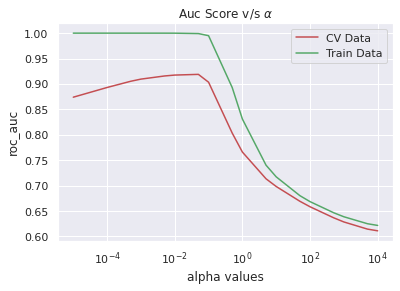

****************************************************************************************************


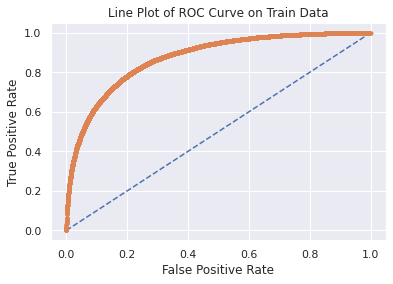

****************************************************************************************************


In [ ]:
# Training NB for BoW
best_alpha_bow = Multinomial_NB(X_tr,X_cv,Y_tr,Y_cv)

##Testing NB on BoW

AUC Score 0.9209823342029133
**********************************************************************


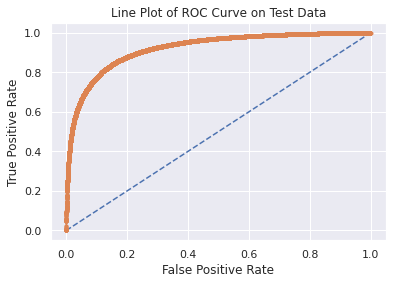

macro f1 score for data : 0.6467429611555733
micro f1 score for data: 0.8739359444818892
hamming loss for data: 0.12606405551811078
**********************************************************************
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.87      0.23      0.36     18834
           1       0.87      0.99      0.93    101343

    accuracy                           0.87    120177
   macro avg       0.87      0.61      0.65    120177
weighted avg       0.87      0.87      0.84    120177

**********************************************************************


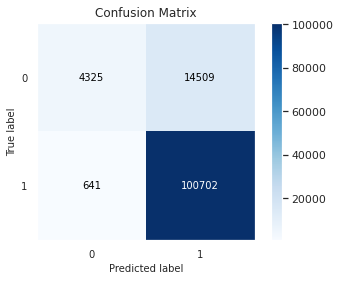

In [ ]:
NB_bow,roc_auc_bow = Testing_model(X_tr,Y_tr,X_test,Y_test,best_alpha_bow)

##Top Features from BoW

In [ ]:
Important_features(BOW,NB_bow)

,Pos_Words,Pos_Importance,Neg_Words,Neg_Importance
0,like,-5.194557,like,-5.485752
1,great,-5.274154,taste,-5.951648
2,good,-5.386931,product,-5.981940
3,love,-5.495140,would,-5.992919
4,one,-5.646232,one,-6.100033
...,...,...,...,...
3474704,home jalapeno,-16.904796,phony chemically,-15.772229
3474705,home jam,-16.904796,phony cappuccinos,-15.772229
3474706,together actually,-16.904796,phony butter,-15.772229
3474707,home jammies,-16.904796,phony baloney,-15.772229


#Term Frequency-Inverse Document Frequency (TF-IDF) Implementation

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

TfIdf,X = Text_Into_Vector(TfidfVectorizer,data['CleanedText'])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (364171, 3474709)
the number of unique words including both unigrams and bigrams  3474709


In [ ]:
TfIdf.get_feature_names()[:20]

['aaa',
 'aaa aaa',
 'aaa able',
 'aaa class',
 'aaa cola',
 'aaa condition',
 'aaa dont',
 'aaa hockey',
 'aaa job',
 'aaa magazine',
 'aaa plus',
 'aaa rating',
 'aaa tue',
 'aaaa',
 'aaaaaaaaagghh',
 'aaaaaaarrrrrggghhh',
 'aaaaaaarrrrrggghhh dark',
 'aaaaaah',
 'aaaaaah melt',
 'aaaaaahhh']

In [ ]:
TfIdf.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 2),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [ ]:
# Split data for train, CV and test
X_tr,X_cv,X_test,Y_tr,Y_test,Y_cv,X_train,Y_train = Split_data(X,data['Score'])

In [ ]:
print('X_test, Y_test', X_test.shape, Y_test.shape)
print('X_tr, Y_tr', X_tr.shape, Y_tr.shape)
print('X_cv, Y_cv', X_cv.shape, Y_cv.shape)
print('X_Train, Y_Train', X_train.shape, Y_train.shape)

X_test, Y_test (120177, 3474709) (120177,)
X_tr, Y_tr (163475, 3474709) (163475,)
X_cv, Y_cv (80519, 3474709) (80519,)
X_Train, Y_Train (243994, 3474709) (243994,)


In [ ]:
# Normalization
X_tr,X_cv,X_test = Normalization(X_tr,X_cv,X_test)

Train Data Size  (163475, 3474709)
CV Data Size:  (80519, 3474709)
Test Data Size:  (120177, 3474709)


##Multinomial NB for TF-IDF

10000  ------>  0.6374523430571146
5000  ------>  0.6381727888543773
1000  ------>  0.6430910743700347
500  ------>  0.6476871462307296
100  ------>  0.6668859458766916
50  ------>  0.6791041302228038
10  ------>  0.7150002552856136
5  ------>  0.7337342666031237
1  ------>  0.7933609275264643
0.5  ------>  0.8298920705520662
0.1  ------>  0.8983067251447
0.05  ------>  0.9012337852272319
0.01  ------>  0.8933885443603953
0.005  ------>  0.890919159111641
0.001  ------>  0.882478944138137
0.0005  ------>  0.8773440941903231
0.0001  ------>  0.8638083811921488
5e-05  ------>  0.857866377889614
1e-05  ------>  0.8448007833396809
****************************************************************************************************

 Best alpha Value 0.05 with highest roc_auc Score is 0.9012337852272319
****************************************************************************************************


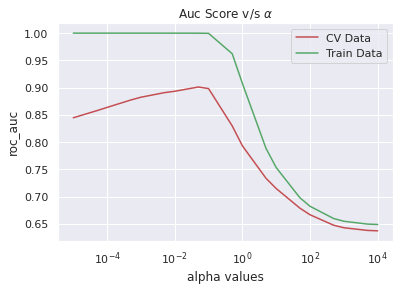

****************************************************************************************************


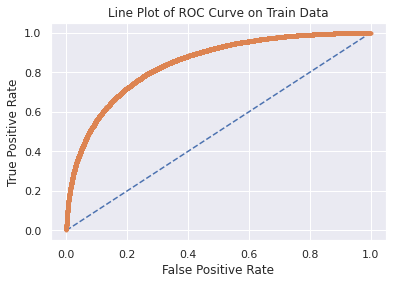

****************************************************************************************************


In [ ]:
best_alpha_idf = Multinomial_NB(X_tr,X_cv,Y_tr,Y_cv)

## Testing NB on TF-IDF

AUC Score 0.904010060518541
**********************************************************************


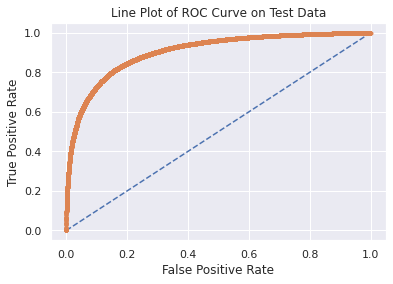

macro f1 score for data : 0.7375149782110274
micro f1 score for data: 0.8872579611739351
hamming loss for data: 0.11274203882606489
**********************************************************************
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.75      0.42      0.54     18834
           1       0.90      0.97      0.94    101343

    accuracy                           0.89    120177
   macro avg       0.83      0.70      0.74    120177
weighted avg       0.88      0.89      0.87    120177

**********************************************************************


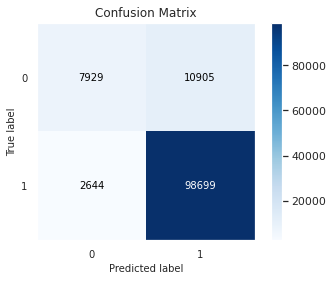

In [ ]:
NB_tfidf,roc_auc_idf = Testing_model(X_tr,Y_tr,X_test,Y_test,best_alpha_idf)

#Top Features from TF-IDF

In [ ]:
Important_features(TfIdf,NB_tfidf)

,Pos_Words,Pos_Importance,Neg_Words,Neg_Importance
0,great,-6.374487,like,-6.744460
1,like,-6.423118,taste,-7.018721
2,good,-6.501029,product,-7.029185
3,love,-6.541061,would,-7.041933
4,coffee,-6.732261,one,-7.241319
...,...,...,...,...
3474704,prejudge coffee,-16.867552,phony chemically,-15.752789
3474705,going pouring,-16.867552,phony cappuccinos,-15.752789
3474706,going powdered,-16.867552,phony butter,-15.752789
3474707,going practices,-16.867552,phony baloney,-15.752789


#Conclusion

In [ ]:
from prettytable import PrettyTable
x=PrettyTable()
x.field_names = ['Vectorizer', 'Model','Hyperparameter(alpha)','Test AUC Score']

x.add_row(['BoW','MultinomialNB',best_alpha_bow,roc_auc_bow])
x.add_row(['TF-IDF','MultinomialNB',best_alpha_idf,roc_auc_idf])

from IPython.display import Markdown,display
def printmd(string):
  display(Markdown(string))

printmd('Final Conclusion for Multinomial NB Model:')
print(x)

Final Conclusion for Multinomial NB Model:

+------------+---------------+-----------------------+--------------------+
| Vectorizer |     Model     | Hyperparameter(alpha) |   Test AUC Score   |
+------------+---------------+-----------------------+--------------------+
|    BoW     | MultinomialNB |          0.05         | 0.9209823342029133 |
|   TF-IDF   | MultinomialNB |          0.05         | 0.904010060518541  |
+------------+---------------+-----------------------+--------------------+


#Individual Prediction Testing

In [ ]:
# print('Enter Text for Sentiment Analysis')
# review=input()
review = """The worst, worse alternative to the usual bhujia we Indians are used to having along with our tea or our beer.
            Much more salt than traditional tea snacks as well. I hate the variety of texture as well with the very 
            crunchy peas to soft cheese bits, the sesame seed coated snack to bad roasted peanuts. It is very 
            expensive though, at 600rs at a kilo perhaps the most expensive tea snack Ive ever had."""
print('Prediction using BoW:',Individual_Prediction(BOW,NB_bow,review))
print('Prediction using TF-IDF:',Individual_Prediction(TfIdf,NB_tfidf,review))

Prediction using BoW: positive review
Prediction using TF-IDF: positive review
